In [1]:
import warnings
warnings.filterwarnings('ignore')
# import quandl
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing, cross_validation, svm, metrics
from sklearn.linear_model import LinearRegression,LassoCV,Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import style
import time, datetime

style.use('ggplot')

/home/ayrus/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('data/train.csv')
# df.fillna(0,inplace=True)
# print(len(df))
print(df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

In [3]:
numfeat = df.select_dtypes(exclude=["object"]).columns
train_num = df[numfeat]
#print(train_num.shape)

catfeat = df.select_dtypes(include=["object"]).columns
train_cat = df[catfeat]

In [4]:
df_main = train_num
df_main.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [5]:
all_data = df.reset_index(drop=True)

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

# f, ax = plt.subplots(figsize=(15, 12))
# plt.xticks(rotation='90')
# sns.barplot(x=all_data_na.index, y=all_data_na)
# plt.xlabel('Features', fontsize=15)
# plt.ylabel('Percent of missing values', fontsize=15)
# plt.title('Percent missing data by feature', fontsize=15)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [6]:
for c in catfeat:
    lbl = LabelEncoder() 
    lbl.fit(list(train_cat[c].values)) 
    df_main[c] = lbl.transform(list(train_cat[c].values))

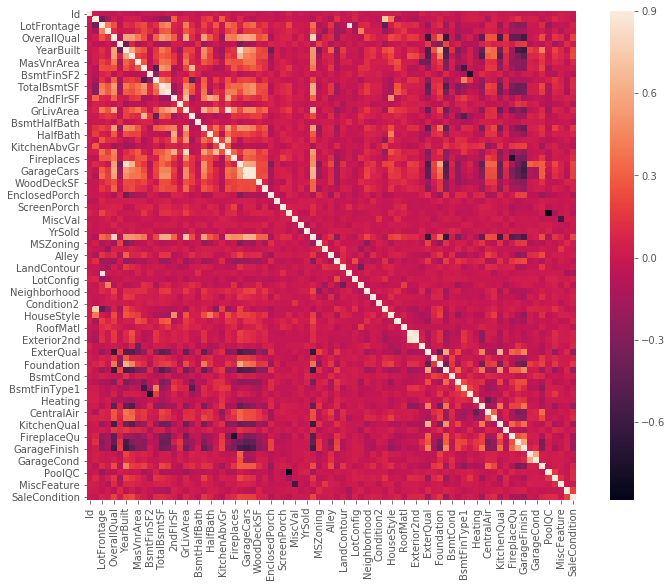

In [8]:
cor  = df_main.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(cor, vmax=0.9, square=True)

In [29]:
# drop_columns = ['YrSold','ScreenPorch','MiscVal','PoolArea','EnclosedPorch','Exterior2nd']
drop_columns = ['ScreenPorch']
p = df_main.drop(drop_columns,1)

df_main.fillna(0,inplace=True)
X = np.array(p.drop(['SalePrice'],1))

y = np.array(df_main['SalePrice'])
X.shape

(1460, 79)

In [30]:
df_main.iloc[:0]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition


In [31]:
# X = preprocessing.scale(X)
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X.shape

(1460, 79)

In [32]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)
tain_size = 1450
X_train = X[:tain_size ]
X_test = X[tain_size:]
y_train = y[:tain_size ]
y_test = y[tain_size:]

In [33]:
# model = LinearRegression()
# score = 0
# index = 0
# for i in range(1,100):
#     model = KNeighborsRegressor(n_neighbors=i)
#     model.fit(X_train,y_train)
#     s = model.score(X_test,y_test)
#     if(s>score):
#         score = s
#         index = i
# print(score,index)


In [34]:
model = KNeighborsRegressor(n_neighbors=4,)
model.fit(X_train,y_train)
model.score(X_test,y_test)


0.61446386890355531

In [35]:
#RandomForestRegressor to predict best spot
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model = model.fit(X_train, y_train)
model.score(X_test,y_test)


0.81490635654690347

In [36]:
#AdaBoostRegressor to predict best spot
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor()
model = model.fit(X_train, y_train)
model.score(X_test,y_test)

0.8392390111268816

In [1]:
#GradientBoostingRegressor to predict best spot
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.02,
                                   max_depth=4, max_features='exp',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model = model.fit(X_train, y_train)
model.score(X_test,y_test)

NameError: name 'X_train' is not defined

In [40]:
# #BaggingRegressor to predict best spot
# from sklearn.ensemble import BaggingRegressor

# model = BaggingRegressor()
# model = model.fit(X_train, y_train)
# model.score(X_test,y_test)

In [41]:
# #ExtraTreesRegressor to predict best spot
# from sklearn.ensemble import ExtraTreesRegressor

# model = BaggingRegressor()
# model = model.fit(X_train, y_train)
# model.score(X_test,y_test)

In [42]:
# #ExtraTreesRegressor to predict best spot
# from sklearn.ensemble import ExtraTreesRegressor

# model = BaggingRegressor()
# model = model.fit(X_train, y_train)
# model.score(X_test,y_test)

In [43]:
#validation function 
n_folds = 5
def rmsle_cv(mdl):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(mdl, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
# rmsle_cv(model)

In [44]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [45]:
y_pred = model.predict(X_test)
rmsle(y_test,y_pred)

16200.656502112033

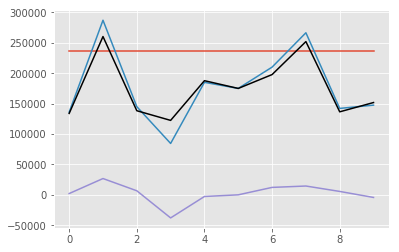

In [46]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from sklearn import metrics
mean = y_test.mean()
std = y_test.std()
plt.plot([std+mean for _ in range(len(y_test))])
plt.plot(y_test)
plt.plot(y_pred,color='black')
plt.plot(y_test - y_pred)
plt.show()

In [47]:
df_test = pd.read_csv('data/test.csv')
df_test = df_test.drop(drop_columns,1)
# print(len(df))
df_test.fillna(-9999,inplace=True)
# df_test.head()
numfeat = df_test.select_dtypes(exclude=["object"]).columns
df_num = df_test[numfeat]

catfeat = df_test.select_dtypes(include=["object"]).columns
df_cat = df_test[catfeat]

df_test = df_num
df_num.shape

(1459, 36)

In [48]:
for c in catfeat:
    lbl = LabelEncoder() 
    lbl.fit(list(df_cat[c].values)) 
    df_test[c] = lbl.transform(list(df_cat[c].values))
df_test.shape

(1459, 79)

In [49]:
X_t = np.array(df_test)
X_t

array([[  1.46100000e+03,   2.00000000e+01,   8.00000000e+01, ...,
          0.00000000e+00,   9.00000000e+00,   4.00000000e+00],
       [  1.46200000e+03,   2.00000000e+01,   8.10000000e+01, ...,
          1.00000000e+00,   9.00000000e+00,   4.00000000e+00],
       [  1.46300000e+03,   6.00000000e+01,   7.40000000e+01, ...,
          0.00000000e+00,   9.00000000e+00,   4.00000000e+00],
       ..., 
       [  2.91700000e+03,   2.00000000e+01,   1.60000000e+02, ...,
          0.00000000e+00,   9.00000000e+00,   0.00000000e+00],
       [  2.91800000e+03,   8.50000000e+01,   6.20000000e+01, ...,
          3.00000000e+00,   9.00000000e+00,   4.00000000e+00],
       [  2.91900000e+03,   6.00000000e+01,   7.40000000e+01, ...,
          0.00000000e+00,   9.00000000e+00,   4.00000000e+00]])

In [50]:
X_t = scaler.transform(X_t)
X_t

array([[ 1.73323755, -0.87256276,  0.46696439, ..., -9.71025321,
         0.95837617,  0.2085023 ],
       [ 1.73561022, -0.87256276,  0.46722437, ..., -7.23479142,
         0.95837617,  0.2085023 ],
       [ 1.7379829 ,  0.07337496,  0.46540452, ..., -9.71025321,
         0.95837617,  0.2085023 ],
       ..., 
       [ 5.18784929, -0.87256276,  0.48776259, ..., -9.71025321,
         0.95837617, -3.42628403],
       [ 5.19022196,  0.66458604,  0.46228479, ..., -2.28386783,
         0.95837617,  0.2085023 ],
       [ 5.19259463,  0.07337496,  0.46540452, ..., -9.71025321,
         0.95837617,  0.2085023 ]])

In [51]:
y_out = model.predict(X_t)
print(y_out)

[ 121300.88954259  152904.05737155  174681.37224724 ...,  156838.52380006
  125790.88444332  206121.84208172]


In [52]:
index = np.array([x for x in range(1461,2920)])
df_out = pd.DataFrame()
df_out = pd.DataFrame(index)
df_out['SalePrice'] = pd.DataFrame(y_out)
df_out = df_out.rename(columns={0:'Id'})

In [53]:
df_out.to_csv('out.csv',index=None,header=['Id','SalePrice'])